In [1]:

# Requirements: Matplotlib, Numpy, functions_util.py, index.py#, fitting_functions_ZNE.py, h5py

import os

#Move the directory back to Duke_Data
#Check if the current directory is Duke_Data
if os.getcwd().split('/')[-1] != 'DUKE_ANALOG_ZNE_DATA':
    #os.chdir('Duke_Data')
    os.chdir('../')
    #print(os.getcwd().split('/')[-1])
    #pass
else:
    pass
#print(os.getcwd())
from util.index import print_index, get_experiment, index_folder
from util.functions_util import cetina_thermal_exp, cetina_envelope_exp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import numpy as np
import h5py
from util.fitting_functions_ZNE import linear_ZNE, third_no_first_ZNE


def fit(function, x_axis, y_axis, return_cov=False, p0=[.05,2000000], weights=None):
    # Fit the data to the function
    popt, pcov = curve_fit(function, x_axis, y_axis, p0=p0, sigma=weights, absolute_sigma=True, maxfev=10000)
    
    if return_cov:
        return popt, pcov
    return popt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# import all the useful lib in python
from matplotlib import artist as art
%matplotlib inline
import scipy as sp
# import pandas as pd
import pathlib
import os
import datetime as dt
import glob
from IPython.display import clear_output
from numpy.fft import fft, ifft

from util.h5analysis import *
from util.qsim_functions import*


In [63]:

#pairs = [(11,12), (12,13),(13,14)]
#bases = ['x', 'y', 'z']
#pairs_names = [265, 259, 266]
# basis_names = [268, 271, 269]
# foldername = 'Population_4_tw0'
# pairs_names = [str(name) for name in pairs_names]
# qubits = [11,12,13,14]
# shots = 150


#For Bz = 4
# phases = np.array([ 1, 2, 3, 4, 5, 6])*np.pi/6
# phase_names = [572, 573, 574, 575, 576, 577]
# phases_pop = np.array([0])*np.pi/6
# pop_name = [571]
# foldername = '15_chain_4_qubit_B=4'
# shots_pop = 200
#Angle should be 

phases = np.array([1, 2, 3, 4, 5, 6])*np.pi/6
phase_names = [563, 564, 567, 568, 569, 570]
phases_pop = np.array([0])*np.pi/6
pop_name = [562]
shots_pop = 600
foldername = '15_chain_4_qubit_B=6'

qubits = [2,3,4,5]
#shots = 600
shots = 200
time_steps = 21



# for name_index in range(len(pairs_names)):
#     name = pairs_names[name_index]
#     if '000563' in pairs_names:
#         pass
#     else:
#         name = '000563' + name
#         pairs_names[name_index] = name
phase_names = [str(name) for name in phase_names]
for name_index in range(len(phase_names)):
    name = phase_names[name_index]
    if '000572' in phase_names:
        pass
    else:
        name = '000572' + name
        phase_names[name_index] = name
        
pop_name = [str(name) for name in pop_name]
for name_index in range(len(pop_name)):
    name = pop_name[name_index]
    if '000572' in pop_name:
        pass
    else:
        name = '000572' + name
        pop_name[name_index] = name
full_data_folder_path = './data/' + foldername + '/'


In [64]:
COUNTS_THRESHOLD = 1


In [65]:
measurement_data = np.zeros((time_steps, len(phase_names)), dtype=dict)
#flopping_matrix = np.zeros((30, len(pairs_names)))
#flopping_std_matrix = np.zeros((30, len(pairs_names)))
#times = None

expectations_matrix = np.zeros((time_steps,len(phase_names)))
qubit_0_magnetization = np.zeros((time_steps,len(phase_names)))
leakage_factor = np.zeros((time_steps,len(phase_names)))

print(os.getcwd())
for file_id_index in range(len(phase_names)):
    
    file_id = phase_names[file_id_index]
    phase = phases[file_id_index]
    #pair = names[0]
    file = h5py.File(full_data_folder_path + file_id + '-RFSoCSequence.h5', 'r')
    archive = file['archive']
    dataset = file['datasets']
    x_vals = dataset['data.rfsoc_pulse_sequence.x_values']
    times = np.array(x_vals)
    if file_id_index == 0:
        times_start = times
    if file_id_index == 3:
        times_end = times
    #print(times)
    raw_counts = dataset['data.rfsoc_pulse_sequence.raw_counts']
    counts = np.asarray(raw_counts)
    #print(counts[:,0])
    #print(counts.shape)
    measurements = np.zeros((len(qubits), shots, time_steps))
    for qubit_index in range(len(qubits)):
        qubit = qubits[qubit_index]
        #qubit = pair[pair_index]
        measurements[qubit_index,:,:] = 1 < counts[qubit,:,:]
        #print(measurements)
    #Convert the measurements to bitstrings. Convert to string, then append the like indices
    counts_bitstrings = np.zeros((shots, time_steps), dtype='<U5')
    for i in range(shots):
        for j in range(time_steps):
            bitstring = [str(int(measurements[qubit_index,i,j])) for qubit_index in range(len(qubits))]
            bitstring = "".join(bitstring)
            counts_bitstrings[i,j] = bitstring
    counts_dicts = np.zeros(time_steps, dtype=dict)
    for j in range(time_steps):
        magnetization = 0
        for shot_index in range(shots):
            magnetization += measurements[0, shot_index, j]*2 - 1
        qubit_0_magnetization[j,file_id_index] = magnetization/shots
        temp_dict = {}#
        #{'0000':0, '1111':0}
        for i in range(shots):
            if counts_bitstrings[i,j] in temp_dict:
                temp_dict[counts_bitstrings[i,j]] += 1/shots
            else:
                temp_dict[counts_bitstrings[i,j]] = 1/shots
        counts_dicts[j] = temp_dict
        expectation = 0
        for key in temp_dict.keys():
            #count the number of zeros. If it is even, add the value. If it is odd, subtract the value
            num_zeros = key.count('0')
            if num_zeros % 2 == 0:
                expectation += temp_dict[key]
            else:
                expectation -= temp_dict[key]
        expectations_matrix[j,file_id_index] = expectation
        print(expectation)
    measurement_data[:,file_id_index] = counts_dicts
    
    

    
#print(counts_array)

/Users/thomassteckmann/Duke_Analog_ZNE_data
0.27000000000000035
0.3100000000000003
0.4300000000000004
0.47000000000000025
0.3300000000000003
0.40000000000000024
0.27000000000000024
0.20000000000000018
0.24000000000000013
0.25000000000000017
0.35000000000000037
0.3200000000000004
0.45000000000000034
0.40000000000000036
0.29000000000000037
0.23000000000000012
-0.02999999999999993
-0.11000000000000003
-0.05999999999999988
0.1800000000000002
0.26000000000000023
0.35000000000000026
0.4400000000000003
0.3600000000000003
0.19000000000000025
0.2400000000000003
-0.05999999999999987
-0.19999999999999996
-0.19999999999999998
-0.33999999999999986
-0.19999999999999996
0.08000000000000015
0.1600000000000002
0.3900000000000002
0.1300000000000002
0.18000000000000016
0.21000000000000013
0.42000000000000015
0.41000000000000025
0.6000000000000002
0.5100000000000001
0.54
-0.09000000000000005
-0.11000000000000006
0.1300000000000001
0.15000000000000008
0.21000000000000008
0.12000000000000005
0.3400000000000

In [66]:
#Good keys are keys which are hamming distance 1 away from 0000 or 1111
all_good_keys = ['0000', '1111', '0001', '0010', '0100', '1000', '1110', '1101', '1011', '0111']
all_good_keys=['0000','1111']

In [67]:
measurement_data_pop = np.zeros((time_steps, len(pop_name)), dtype=dict)
#flopping_matrix = np.zeros((30, len(pairs_names)))
#flopping_std_matrix = np.zeros((30, len(pairs_names)))
#times = None

expectations_matrix_pop = np.zeros((time_steps,len(pop_name)))
expectation_ZZZZ_pop = np.zeros((time_steps,len(pop_name)))
qubit_0_magnetization_pop = np.zeros((time_steps,len(pop_name)))
leakage_factor_pop = np.zeros((time_steps,len(pop_name)))

print(os.getcwd())
for file_id_index in range(len(pop_name)):
    
    file_id = pop_name[file_id_index]
    phase = phases_pop[file_id_index]
    #pair = names[0]
    file = h5py.File(full_data_folder_path + file_id + '-RFSoCSequence.h5', 'r')
    archive = file['archive']
    dataset = file['datasets']
    x_vals = dataset['data.rfsoc_pulse_sequence.x_values']
    times = np.array(x_vals)
    if file_id_index == 0:
        times_start = times
    if file_id_index == 3:
        times_end = times
    #print(times)
    raw_counts = dataset['data.rfsoc_pulse_sequence.raw_counts']
    counts = np.asarray(raw_counts)
    print(counts.shape)
    measurements = np.zeros((len(qubits), shots_pop, time_steps))
    for qubit_index in range(len(qubits)):
        qubit = qubits[qubit_index]
        #qubit = pair[pair_index]
        measurements[qubit_index,:,:] = 1 < counts[qubit,:,:]
        #print(measurements)
    #Convert the measurements to bitstrings. Convert to string, then append the like indices
    counts_bitstrings = np.zeros((shots_pop, time_steps), dtype='<U5')
    for i in range(shots_pop):
        for j in range(time_steps):
            bitstring = [str(int(measurements[qubit_index,i,j])) for qubit_index in range(len(qubits))]
            bitstring = "".join(bitstring)
            counts_bitstrings[i,j] = bitstring
    counts_dicts = np.zeros(time_steps, dtype=dict)
    for j in range(time_steps):
        magnetization = 0
        for shot_index in range(shots_pop):
            magnetization += measurements[0, shot_index, j]*2 - 1
        qubit_0_magnetization_pop[j,file_id_index] = magnetization/shots_pop
        temp_dict = {}#
        #{'0000':0, '1111':0}
        for i in range(shots_pop):
            if counts_bitstrings[i,j] in temp_dict:
                temp_dict[counts_bitstrings[i,j]] += 1/shots_pop
            else:
                temp_dict[counts_bitstrings[i,j]] = 1/shots_pop
        counts_dicts[j] = temp_dict
        expectation = 0
        expectation_ZZZZ = 0
        print('---')
        for key in temp_dict.keys():
            print(key, temp_dict[key])
            if key in all_good_keys:
                expectation += temp_dict[key]
                
            count_zero = key.count('0')
            if count_zero % 2 == 0:
                expectation_ZZZZ += temp_dict[key]
            else:
                expectation_ZZZZ -= temp_dict[key]
        expectation_ZZZZ_pop[j,file_id_index] = expectation_ZZZZ

        expectations_matrix_pop[j,file_id_index] = expectation
        #print(expectation)
    measurement_data_pop[:,file_id_index] = counts_dicts
    
    

    
#print(counts_array)

/Users/thomassteckmann/Duke_Analog_ZNE_data
(15, 600, 21)
---
1111 0.2700000000000004
1011 0.048333333333333305
1000 0.06833333333333327
1100 0.030000000000000002
0011 0.02
1110 0.06833333333333327
0111 0.08499999999999991
0000 0.22166666666666712
0110 0.016666666666666666
0001 0.034999999999999996
1101 0.034999999999999996
1010 0.01
0100 0.034999999999999996
0101 0.015000000000000001
0010 0.028333333333333335
1001 0.013333333333333334
---
0000 0.24000000000000057
1011 0.06666666666666661
0010 0.02666666666666667
1110 0.05999999999999995
1111 0.2700000000000004
0100 0.04999999999999997
0111 0.06833333333333327
1100 0.03666666666666666
1010 0.013333333333333334
0110 0.021666666666666667
1001 0.013333333333333334
0001 0.02666666666666667
1101 0.025
0101 0.016666666666666666
1000 0.03999999999999999
0011 0.025
---
0001 0.03333333333333333
0111 0.07499999999999993
0110 0.03333333333333333
1111 0.2966666666666668
0100 0.043333333333333314
0000 0.25166666666666726
1101 0.034999999999999996
1

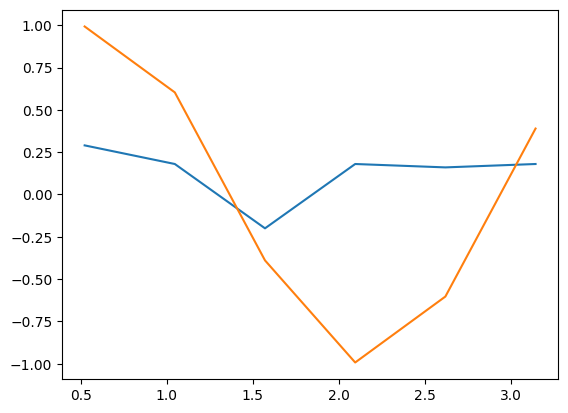

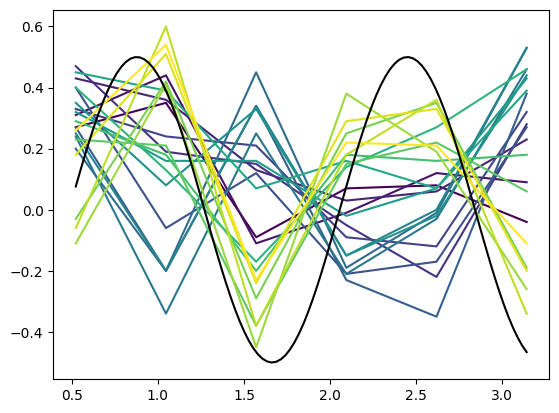

In [68]:
data_matrix = np.zeros((time_steps, len(phase_names)))
for i in range(len(phase_names)):
    data_matrix[:,i] = expectations_matrix[:,i]
plt.plot(phases, data_matrix[14,:])
plt.plot(phases, np.sin(2*np.array(phases)+0.4))
#Plot each index int he time step using a different color from a color bar
fig, ax = plt.subplots()
colors = cm.viridis(np.linspace(0, 1, time_steps))
for i in range(time_steps):
    ax.plot(phases, data_matrix[i,:], color=colors[i], label=i/time_steps*2*np.pi)
phases_dense = np.linspace(np.pi/6, np.pi, 100)
ax.plot(phases_dense, -0.5*np.sin(4*np.array(phases_dense)+1.2 ), color='black', label='Sin fit')
#cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=ax)
#plt.legend()

6
1.8849555921538759
0.3669241523040614


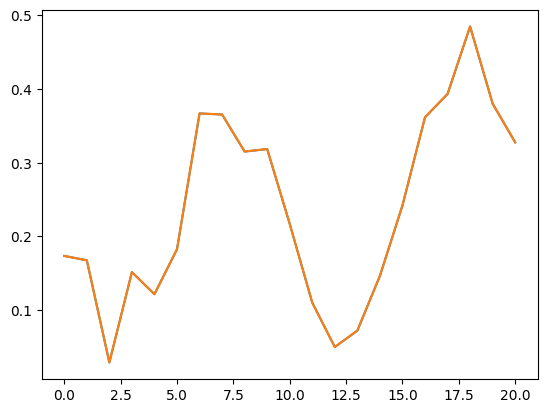

In [73]:
amps = np.zeros(time_steps)
for i in range(time_steps):
    test = data_matrix[i,:]
    fft_test = np.fft.fft(test)*2/len(test)
    frequencies = np.fft.fftfreq(len(test), phases[0]-phases[1])*2*np.pi
    #print(frequencies)
    amp_4 = np.abs(fft_test[4])
    amps[i] = amp_4
amps_fit = np.zeros(time_steps)
def sin_fit(x, a, b,c):
    return np.sin(4*x + c)*a + b

for i in range(time_steps):
    test = data_matrix[i,:]
    popt, pcov = curve_fit(sin_fit, phases, test, p0=[0.5,0,0])
    amps_fit[i] = abs(popt[0])
    
    
plt.plot(range(time_steps), amps)
plt.plot(range(time_steps), amps_fit)
#return the index of the maximum amplitude
max_index = np.argmax(amps_fit[:-12])
print(max_index)
Z_rotations = np.linspace(0, 2*np.pi, time_steps, endpoint=True)
print(Z_rotations[max_index])
print(amps_fit[max_index])


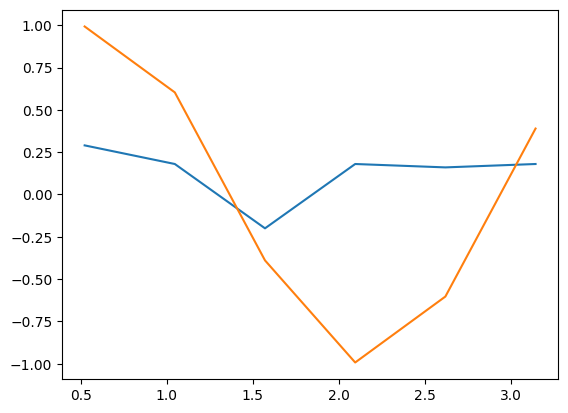

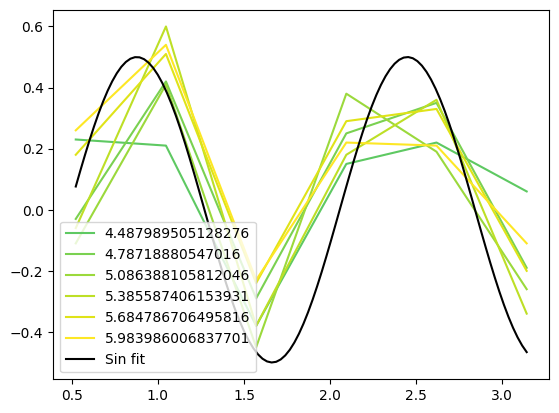

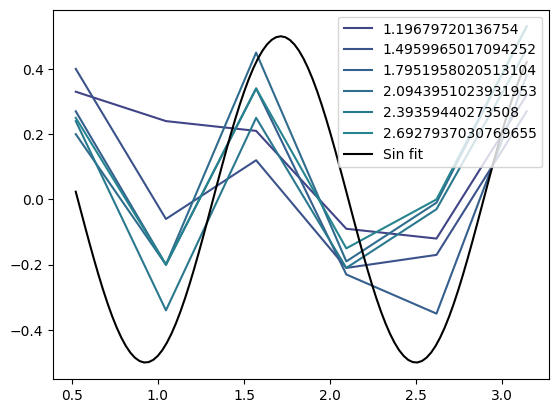

In [70]:
data_matrix = np.zeros((time_steps, len(phase_names)))
for i in range(len(phase_names)):
    data_matrix[:,i] = expectations_matrix[:,i]
plt.plot(phases, data_matrix[14,:])
plt.plot(phases, np.sin(2*np.array(phases)+0.4))
#Plot each index int he time step using a different color from a color bar
fig, ax = plt.subplots()
colors = cm.viridis(np.linspace(0, 1, time_steps))
for i in range(15,time_steps):
    ax.plot(phases, data_matrix[i,:], color=colors[i], label=i/time_steps*2*np.pi)
phases_dense = np.linspace(np.pi/6, np.pi, 100)
ax.plot(phases_dense, -0.5*np.sin(4*np.array(phases_dense)+1.2 ), color='black', label='Sin fit')
#cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=ax)
plt.legend()
plt.show()

fig, ax = plt.subplots()
colors = cm.viridis(np.linspace(0, 1, time_steps))
for i in range(4,10):
    ax.plot(phases, data_matrix[i,:], color=colors[i], label=i/time_steps*2*np.pi)
phases_dense = np.linspace(np.pi/6, np.pi, 100)
ax.plot(phases_dense, 0.5*np.sin(4*np.array(phases_dense)+1 ), color='black', label='Sin fit')
#cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=ax)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3
0.9424777960769379
0.581666666666667


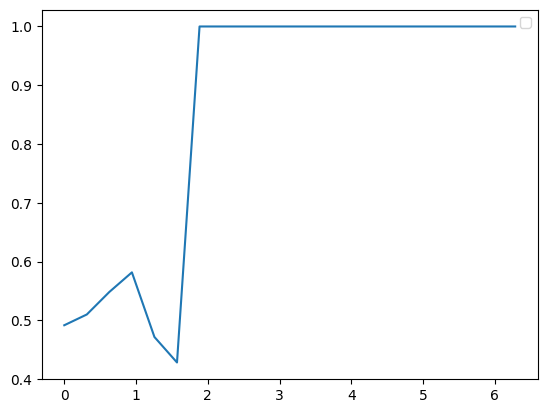

In [76]:

#Plot each index int he time step using a different color from a color bar
fig, ax = plt.subplots()

ax.plot(np.linspace(0, 2*np.pi, time_steps), expectations_matrix_pop[:,0])

#cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=ax)
plt.legend()
#Get the index of the peak:
peak_index = np.argmax(expectations_matrix_pop[:-17,0])
print(peak_index)
print(Z_rotations[peak_index])
print(expectations_matrix_pop[peak_index,0])

IndexError: index 30 is out of bounds for axis 0 with size 21

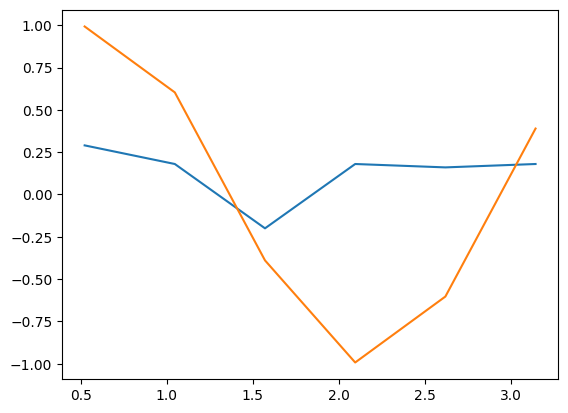

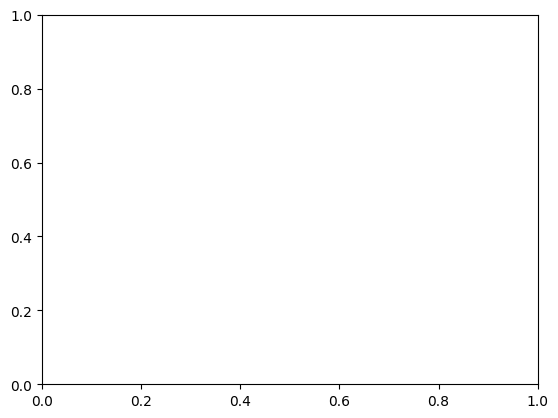

In [72]:
data_matrix = np.zeros((time_steps, len(phase_names)))
for i in range(len(phase_names)):
    data_matrix[:,i] = expectations_matrix[:,i]
plt.plot(phases, data_matrix[14,:])
plt.plot(phases, np.sin(2*np.array(phases)+0.4))
#Plot each index int he time step using a different color from a color bar
fig, ax = plt.subplots()
colors = cm.viridis(np.linspace(0, 1, time_steps))
for i in range(30,34):
    ax.plot(phases, data_matrix[i,:], color=colors[i], label=i/time_steps*2*np.pi)
ax.plot(phases, 0.8*np.sin(2*np.array(phases)+0.6), color='black', label='Sin fit')
#cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=ax)
plt.legend()

In [ ]:
x_axis = [val for val in x_vals]

ValueError: x and y must be the same size

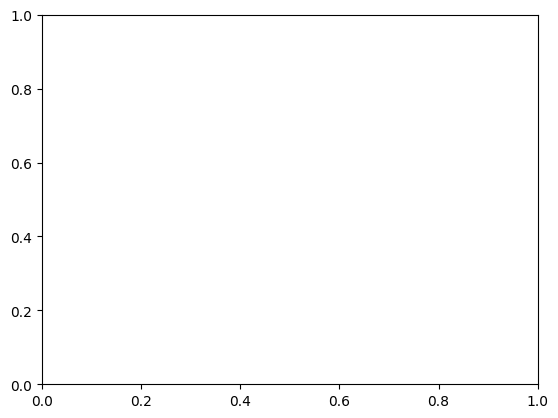

In [ ]:
plt.scatter(phases, expectations_matrix[:,0])
#Fit each of the axies to a sign function:

plt.plot(x_axis, .8*np.cos(np.array(x_axis)*2))

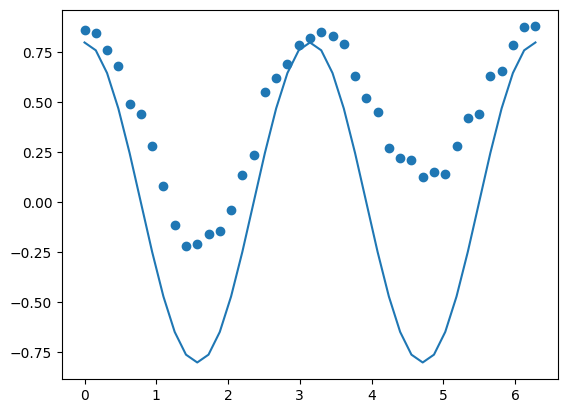

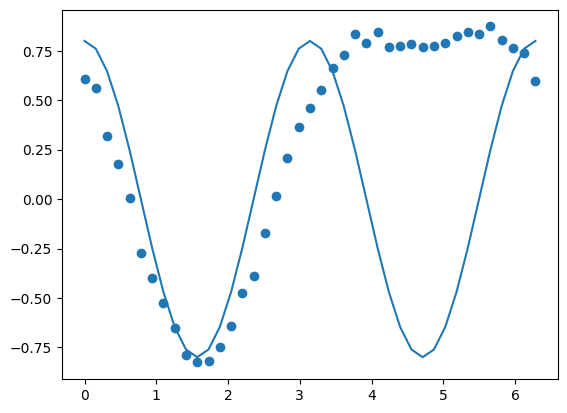

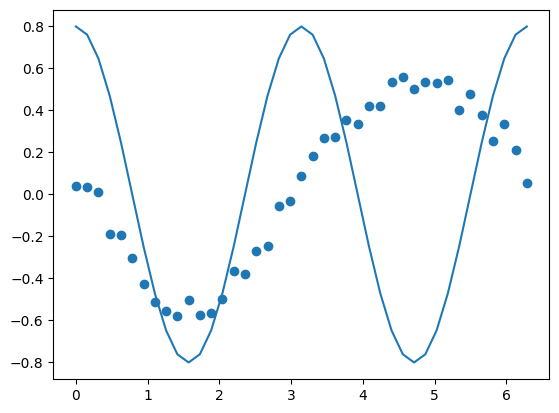

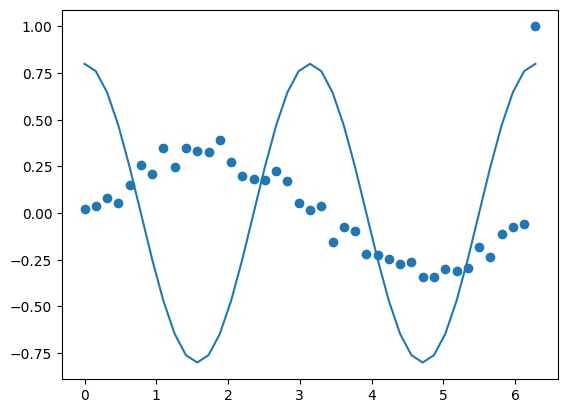

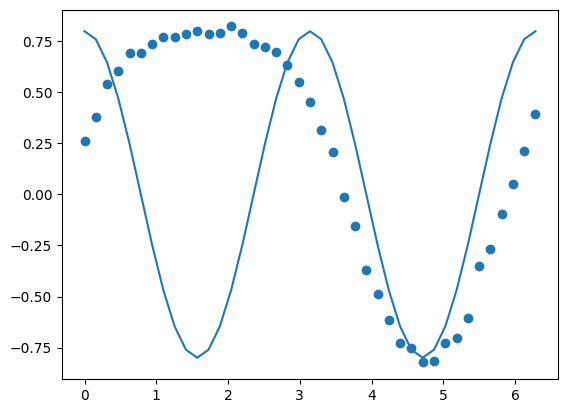

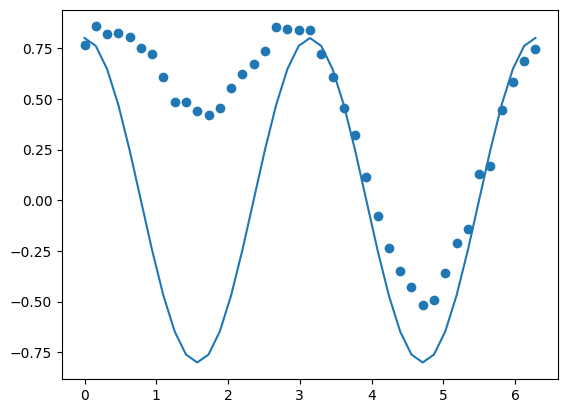

In [ ]:
for i in range(6):
    

    plt.scatter(x_axis, expectations_matrix[:,i])
    #Fit each of the axies to a sign function:

    plt.plot(x_axis, .8*np.cos(np.array(x_axis)*2))
    plt.show()

In [ ]:
print(expectations_matrix)

[[ 0.83]
 [ 0.82]
 [ 0.58]
 [ 0.49]
 [ 0.01]
 [ 0.14]
 [-0.12]
 [-0.15]
 [-0.57]
 [-0.57]
 [-0.53]
 [-0.56]
 [-0.43]
 [-0.34]
 [-0.08]
 [ 0.08]
 [ 0.23]
 [ 0.41]
 [ 0.47]
 [ 0.65]
 [ 0.82]
 [ 0.8 ]
 [ 0.92]
 [ 0.9 ]
 [ 0.8 ]
 [ 0.82]
 [ 0.62]
 [ 0.6 ]
 [ 0.6 ]
 [ 0.53]
 [ 0.48]
 [ 0.6 ]
 [ 0.56]
 [ 0.65]
 [ 0.57]
 [ 0.78]
 [ 0.87]
 [ 0.9 ]
 [ 0.85]
 [ 0.77]
 [ 0.8 ]]


TypeError: Improper input: func input vector length N=4 must not exceed func output vector length M=1

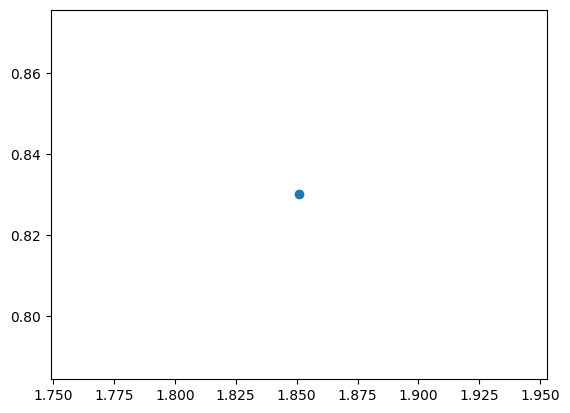

In [ ]:
plt.scatter(phases, expectations_matrix[0,:])
#Fit to a sin function:
def sine(x, A, B, C, D):
    return A*np.sin(B*x + C) + D
phases_sorted = phases.copy()
phases_dense = np.linspace(0, 1.25*np.pi, 1000)
phases_sorted.sort()
popt, pcov = fit(sine, phases, expectations_matrix[0,:], return_cov=True, p0=[.5, 2, 0, 0])
plt.plot(phases_dense, sine(phases_dense, *popt))
print(popt[0])
